# Introduction
## Title:
### Urban Explorer: Machine Learning Driven Discoveries
## Goal:
My project aims to develop a machine learning-based solution that provides personalized recommendations for travelers based on their preferences and past travel history
## Notebook Overview:
The notebook includes steps for exploring and analyzing data for a better understanding of the datasets involved. The final goal of the notebook is to export this cleaned and structured data for further data manipulation and modeling.
## Data Overview:
My data is sourced directly from Yelp. Follow the steps below in order to run the notebook. 
1. The most recent version of this data set can be obtained [here](https://www.yelp.com/dataset)
2. You'll only need the JSON data which will be in a compressed .tgz file
3. Copy decompressed files into the following directory: ~/BrainStation-Capstone/Data/original_data_sets
4. You'll need the three JSON files below, you may delete the rest
    - yelp_academic_dataset_business.json
    - yelp_academic_dataset_review.json
    - yelp_academic_dataset_user.json

# Table of Contents

- [Introduction](#introduction)
- [Setup](#setup)
- [Business Data Set](#business-data-set)
  - [Business Details](#business-details)
  - [Stars](#stars)
  - [Review Count](#review-count)
  - [Is Open](#is-open)
  - [Attributes](#attributes)
  - [Categories](#categories)
  - [Hours](#hours)
- [User Data Set](#user-data-set)
  - [Users](#users)
  - [Review Count](#review-count)
  - [Average Stars](#average-stars)
- [Review Data Set](#review-data-set)
      - [Data Dictionary](#data-dictionary)
  - [Unique Identifiers](#unique-identifiers)
  - [Stars](#stars)
  - [Date](#date)
- [Exporting Data](#exporting-data)



# Setup

Let's get started by importing the required packages and defining some convenience functions. 

In [20]:
# Imports
import pandas as pd
import numpy as np
import json
from collections import defaultdict
import matplotlib.pyplot as plt

# Function to print the structure of the JSON data
def print_json_structure(data, indent=0):
    """
    Prints the structure of the JSON data.

    Parameters:
    data (dict or list): The JSON data to be analyzed.
    indent (int): The indentation level to make it more readable. Default is 0.

    Returns:
    Note: This function prints the structure of the JSON data.
    """
    if isinstance(data, dict):
        for key, value in data.items():
            print(' ' * indent + str(key))
            print_json_structure(value, indent + 2)
    elif isinstance(data, list):
        print(' ' * indent + '[List of {} elements]'.format(len(data)))
        if len(data) > 0:
            print_json_structure(data[0], indent + 2)
    else:
        print(' ' * indent + str(type(data)))

# Check for missing values
def check_missing_values(data):
    """
    Checks for missing values in the dataset.

    Parameters:
    data (list of dict): The dataset to check for missing values.

    Returns:
    dict: A dictionary containing the count of missing values for each key in the dataset.
    """
    all_keys = set()
    for entry in data:
        all_keys.update(entry.keys())
    missing_values = {key: 0 for key in all_keys}
    for entry in data:
        for key in all_keys:
            if key not in entry or entry[key] is None:
                missing_values[key] += 1
    return missing_values

def check_duplicate_ids(data, id_column):
    """
    Check for duplicate IDs in the given dataset.

    Parameters:
    data (list of dict): The dataset to check for duplicates.
    id_column (str): The column name for the ID to check duplicates.

    Returns:
    DataFrame: A DataFrame containing the duplicate IDs and their counts.
    """
    # Convert the data into a DataFrame
    df = pd.DataFrame(data)
    
    # Check for duplicates
    duplicate_ids = df[df.duplicated(subset=[id_column], keep=False)]
    
    # Group by ID and count occurrences
    duplicate_counts = duplicate_ids.groupby(id_column).size().reset_index(name='count')
    
    return duplicate_counts

def plot_distribution(df, column, title, xlabel, ylabel='Frequency', bins=20):
    """
    Plots the distribution of a given column in the DataFrame with mean and median lines.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    column (str): The column name for which the distribution is to be plotted.
    title (str): The title of the plot.
    xlabel (str): The label for the x-axis.
    ylabel (str): The label for the y-axis.
    bins (int): The number of bins for the histogram. Default is 20.
    """
    values = df[column].dropna()
    mean = round(values.mean(), 2)
    median = values.median()

    plt.figure(figsize=(10, 6))
    plt.hist(values, bins=bins, edgecolor='k', alpha=0.7)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.axvline(mean, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean}')
    plt.axvline(median, color='black', linestyle='solid', linewidth=1, label=f'Median: {median}')
    
    plt.legend()
    plt.grid(True)

    plt.show()

# Business Data Set
#### Data Dictionary
Contains business data including location data, attributes, and categories.<br/>
Info sourced from the data set [documentation](https://www.yelp.com/dataset/documentation/main)<br/>

| COLUMN NAME   | DESCRIPTION                                    | DATA TYPE   |
|---------------|------------------------------------------------|-------------|
| `business_id` | 22 character unique string business id         | string      |
| `name`        | The business's name                            | string      |
| `address`     | The full address of the business               | string      |
| `city`        | The city                                       | string      |
| `state`       | 2 character state code, if applicable          | string      |
| `postal_code` | The postal code                                | string      |
| `latitude`    | Latitude                                       | float       |
| `longitude`   | Longitude                                      | float       |
| `stars`       | Star rating(1-5), rounded to half-stars        | float       |
| `review_count`| Number of reviews                              | int         |
| `is_open`     | 0 or 1 for closed or open, respectively        | int         |
| `attributes`  | Business attributes to values                  | dict        |
| `categories`  | Array of strings of business categories        | list        |
| `hours`       | Key day to value hours, hours are using a 24hr clock | dict  |

##### Loading Data
- I'll go ahead load the JSON file which contains multiple JSON objects, each representing a different business.
- I'm going to go ahead and exclude objects the contain null values for certain fields such as name, city, categories, etc. These fields are necessary for either modeling or for filtering purposes.
- I'll also remove the attributes object from each business to conserve memory before converting data into a pandas data frame. 

In [21]:
# Initialize an empty list to hold the data
data = []

# List of required fields
required_fields = ['business_id', 'name', 'city', 'state', 'postal_code', 
                   'latitude', 'longitude', 'stars', 'review_count', 'is_open', 'categories']

# Read the file line by line and parse each JSON object
with open('../Data/original_data_sets/yelp_academic_dataset_business.json') as f:
    for line in f:
        try:
            entry = json.loads(line)
            # Check if all required fields are present and not null
            if all(field in entry and entry[field] is not None for field in required_fields):
                # Exclude the 'attributes' object
                filtered_entry = {key: value for key, value in entry.items() if key != 'attributes'}
                data.append(filtered_entry)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON on line: {line}")
            print(e)
# Checking the number of entries
num_entries = len(data)
print(f"Number of entries: {num_entries}")


Number of entries: 150243


In [22]:
# Inspecting the first entry to understand the structure
print("\nSample entry:")
print(json.dumps(data[0], indent=3))


Sample entry:
{
   "business_id": "Pns2l4eNsfO8kk83dixA6A",
   "name": "Abby Rappoport, LAC, CMQ",
   "address": "1616 Chapala St, Ste 2",
   "city": "Santa Barbara",
   "state": "CA",
   "postal_code": "93101",
   "latitude": 34.4266787,
   "longitude": -119.7111968,
   "stars": 5.0,
   "review_count": 7,
   "is_open": 0,
   "categories": "Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, Nutritionists",
   "hours": null
}


In [23]:
# All unique keys at the top level
keys = set()
for entry in data:
    keys.update(entry.keys())
print(f"\nTop-level keys: {list(keys)}")


Top-level keys: ['business_id', 'categories', 'city', 'longitude', 'name', 'postal_code', 'stars', 'review_count', 'is_open', 'hours', 'state', 'address', 'latitude']


In [24]:
# Summarize data types for each key
data_types = defaultdict(set)
for entry in data:
    for key, value in entry.items():
        data_types[key].add(type(value).__name__)

print("\nData Types:")
for key, types in data_types.items():
    print(f"{key}: {', '.join(types)}")


Data Types:
business_id: str
name: str
address: str
city: str
state: str
postal_code: str
latitude: float
longitude: float
stars: float
review_count: int
is_open: int
categories: str
hours: NoneType, dict


In [25]:
# Checking missing values using function defined earlier
missing_values = check_missing_values(data)
print("Missing Values:")
for key, count in missing_values.items():
    print(f"{key}: {count} missing values")

Missing Values:
business_id: 0 missing values
categories: 0 missing values
city: 0 missing values
longitude: 0 missing values
name: 0 missing values
postal_code: 0 missing values
stars: 0 missing values
review_count: 0 missing values
is_open: 0 missing values
hours: 23120 missing values
state: 0 missing values
address: 0 missing values
latitude: 0 missing values


In [26]:
# Checking duplicate businesses using function defined earlier
check_duplicate_ids(data, 'business_id')

,business_id,count


In [27]:
# Convert the filtered list of dictionaries to a pandas DataFrame
df_b = pd.DataFrame(data)
df_b.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [28]:
# Gives me a a quick look at the data types for each column, number of entries, and columns.
df_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150243 entries, 0 to 150242
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   150243 non-null  object 
 1   name          150243 non-null  object 
 2   address       150243 non-null  object 
 3   city          150243 non-null  object 
 4   state         150243 non-null  object 
 5   postal_code   150243 non-null  object 
 6   latitude      150243 non-null  float64
 7   longitude     150243 non-null  float64
 8   stars         150243 non-null  float64
 9   review_count  150243 non-null  int64  
 10  is_open       150243 non-null  int64  
 11  categories    150243 non-null  object 
 12  hours         127123 non-null  object 
dtypes: float64(3), int64(2), object(8)
memory usage: 14.9+ MB


## Business Details
The first eight columns contain information about the business, such as a business id, name of the business, address, city, state, postal code, and geo-location coordinates.

**City**

In [29]:
df_b['city'].value_counts()

city
Philadelphia      14560
Tucson             9244
Tampa              9042
Indianapolis       7537
Nashville          6969
                  ...  
Danboro               1
Spokane               1
ST. PETE BEACH        1
Mt Ephraim            1
Apollo beach          1
Name: count, Length: 1415, dtype: int64

Interestingly, the dataset seems to represent significantly more cities than initially expected. I will have to do a deeper investigation, as the majority could represent suburbs surrounding major metropolitan areas.

**State**

In [30]:
df_b['state'].value_counts()

state
PA     34013
FL     26309
TN     12051
IN     11243
MO     10907
LA      9916
AZ      9906
NJ      8527
NV      7706
AB      5572
CA      5202
ID      4464
DE      2262
IL      2144
TX         4
CO         3
WA         2
HI         2
MA         2
NC         1
UT         1
MT         1
MI         1
SD         1
XMS        1
VI         1
VT         1
Name: count, dtype: int64

Data represent various states across the US and Canada

**Postal Code**

In [31]:
df_b['postal_code'].value_counts()

postal_code
93101      1865
89502      1803
70130      1512
19103      1362
19107      1353
           ... 
T5G 0N5       1
46211         1
T5K 1C4       1
T6G 0W8       1
T5J 4X6       1
Name: count, Length: 3360, dtype: int64

An interesting thing to note is that Canadian postal codes have a noticeably different format; incorporating non-numeric values may be another layer of difficulty when performing an analysis. 

## Stars 
Column contains the average of all user ratings for a business (rounded to half star).

In [32]:
df_b['stars'].value_counts()

stars
4.0    31120
4.5    27174
3.5    26512
3.0    18448
5.0    16301
2.5    14307
2.0     9515
1.5     4918
1.0     1948
Name: count, dtype: int64

In [33]:
df_b['stars'].agg('average')

3.5976817555559992

Star ratings are given in increments of .5 with 4.0 the most common rating given to businesses and 3.6 being the average rating. 

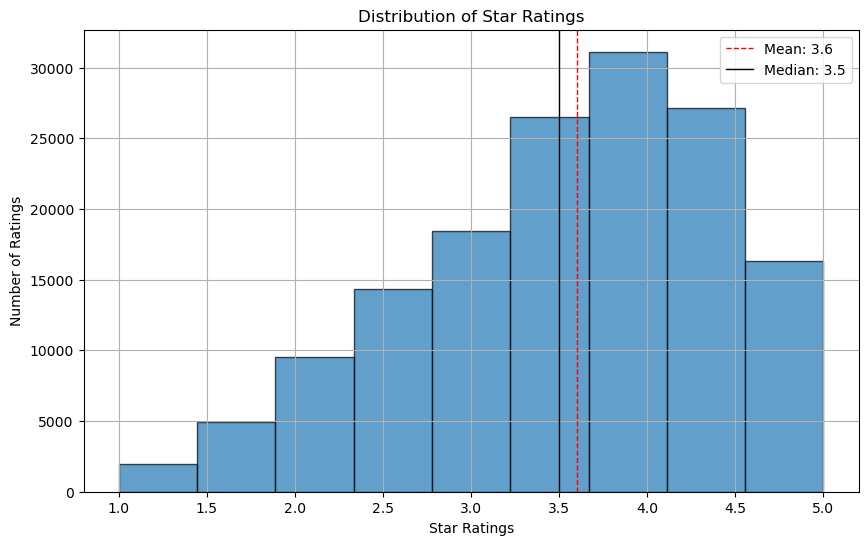

In [34]:
# Distribution for review ratings
plot_distribution(df_b, 'stars', 'Distribution of Star Ratings', 'Star Ratings','Number of Ratings',9)

Plot visualizes a slightly right-skewed distribution. Show users tend to give higher ratings. 

## Review Count 
The column contains a count of the number of user reviews for each business.

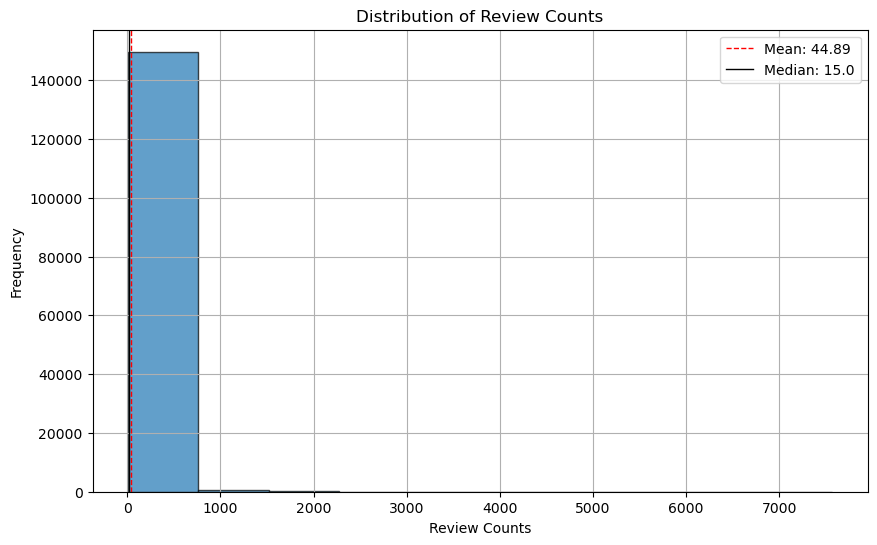

In [35]:
# Review count distribution
plot_distribution(df_b, 'review_count', 'Distribution of Review Counts', 'Review Counts','Frequency', bins=10)

The plot wasn't the best visual, but it did highlight the enormous range in the number of reviews a business receives. The median and mean also give a sense of the spread, the latter being significantly higher at 45 average reviews per business. 

## Is Open
The binary column indicates where a business is still open and operating or permanently closed.

In [36]:
# Count of open and closed businesses
df_b['is_open'].value_counts()

is_open
1    119603
0     30640
Name: count, dtype: int64

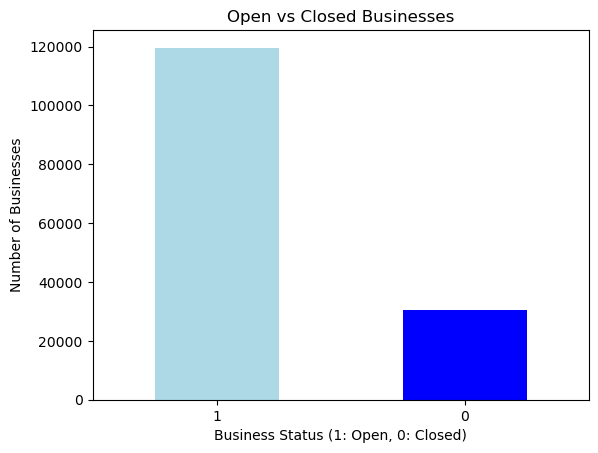

In [37]:
# Plot of open vs closed businesses 
is_open_vc = df_b['is_open'].value_counts()
is_open_vc.plot(kind='bar', color=['lightblue', 'blue'])

plt.title('Open vs Closed Businesses')
plt.xlabel('Business Status (1: Open, 0: Closed)')
plt.ylabel('Number of Businesses')
plt.xticks(rotation=0)

# Save as PNG
#plt.savefig('figures/OpenVsClosedBusinesses.png')

plt.show()

30,640 businesses are closed, which accounts for 20% of the data. On the surface, you probably wouldn't want 'out-of-date' data; however, for my project, it could still be helpful to make connections between users and businesses they visited, regardless of whether they are still open. 

## Categories
[Yelp Categories](https://blog.yelp.com/businesses/yelp_category_list/)<br/>
The column contains a list of categories the business falls under; for more info, click the link above, where Yelp provides a breakdown of their category organization. 

Will be dropping categories not relevent for travelling

In [38]:
# initialize list using counts of each main category I plan on using
category_counts = [['Restaurants', df_b['categories'].str.contains("Restaurants").fillna(False).sum()], 
        ['Food', df_b['categories'].str.contains(", Food,").fillna(False).sum()], 
        ['Active Life', df_b['categories'].str.contains("Active Life").fillna(False).sum()],
        ['Arts & Entertainment', df_b['categories'].str.contains("Arts & Entertainment").fillna(False).sum()],
        ['Hotels & Travel', df_b['categories'].str.contains("Hotels & Travel").fillna(False).sum()],
        ['Nightlife', df_b['categories'].str.contains("Nightlife").fillna(False).sum()]]
 
# Create the pandas DataFrame
df_categories = pd.DataFrame(category_counts, columns=['Category', 'Count'])

# Sort Values
df_categories = df_categories.sort_values('Count', ascending=False)
# print dataframe.
print(df_categories)

               Category  Count
0           Restaurants  52268
1                  Food  14533
5             Nightlife  12281
2           Active Life   7687
4       Hotels & Travel   5857
3  Arts & Entertainment   5434


In [39]:
# Get a total count of all travel related businesses
df_categories['Count'].sum()

98060

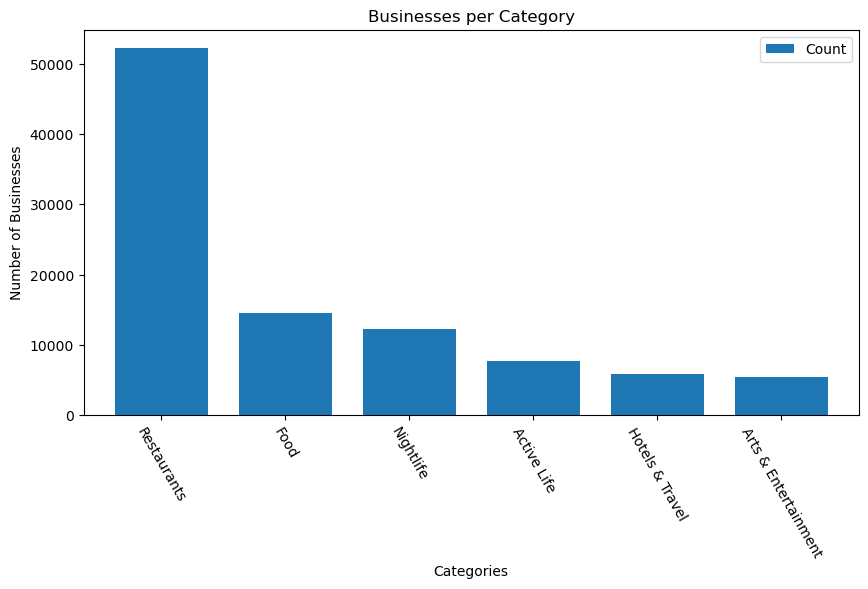

In [40]:
# Plot visualizing 
df_categories.plot('Category', 'Count', kind='bar', width=.75, figsize=(10,5))

# Rotating X-axis labels
plt.xticks(rotation = -60)
 
# Setting title and axis labels
plt.title('Businesses per Category')
plt.xlabel("Categories")
plt.ylabel("Number of Businesses")

# Save bar chart to file
#plt.savefig('figures/BusinessMainCategoriesChart.png', bbox_inches='tight')
 
# Show plot
plt.show()

These six categories represent the businesses you typically would visit when traveling. <br>
Restaurants are by far the most represented business category, which is further broken down by the type of cuisine served. The food category is a catch-all category for any food-related business that isn't a restaurant—places like bakeries, coffee shops, pastry shops, food trucks, etc. The nightlife category contains businesses such as bars, comedy clubs, dance clubs, etc. Active life includes Amusement parks, experiences, parks, zoos, etc. The hotels & travel category can include hotels, hostels, tours, vacation rentals, etc. Lastly, the least represented group can include places such as cultural centers, festivals, museums, etc. 

## Hours
The column contains a dictionary of business hours by day of the week.
This could be important for a future feature, maybe filtering businesses that are open when a user requests a recommendation. 

In [41]:
# Check for null values
df_b['hours'].isna().sum()

23120

May need to address the null values in the future, but will leave alone for now as 'hours' aren't needed for modeling

# User Data Set
#### Data Dictionary
User data including the user's friend mapping and all the metadata associated with the user.<br/>
Info sourced from the data set [documentation](https://www.yelp.com/dataset/documentation/main)<br/>
| COLUMN NAME               | DESCRIPTION                                                        | DATA TYPE |
|---------------------------|--------------------------------------------------------------------|-----------|
| `user_id`                   | Unique user ID                                                     | string    |
| `name`                      | The user's first name                                              | string    |
| `review_count`              | Number of reviews written by the user                              | integer   |
| `yelping_since`             | When the user joined Yelp, formatted as YYYY-MM-DD                 | string    |
| `friends`                   | Array of the user's friends as user_ids                            | array     |
| `useful`                    | Number of useful votes sent by the user                            | integer   |
| `funny`                     | Number of funny votes sent by the user                             | integer   |
| `cool`                      | Number of cool votes sent by the user                              | integer   |
| `fans`                      | Number of fans the user has                                        | integer   |
| `elite`                     | Array of years the user was elite                                  | array     |
| `average_stars`             | Average rating of all reviews                                      | float     |
| `compliment_hot`            | Number of hot compliments received by the user                     | integer   |
| `compliment_more`           | Number of more compliments received by the user                    | integer   |
| `compliment_profile`        | Number of profile compliments received by the user                 | integer   |
| `compliment_cute`           | Number of cute compliments received by the user                    | integer   |
| `compliment_list`           | Number of list compliments received by the user                    | integer   |
| `compliment_note`           | Number of note compliments received by the user                    | integer   |
| `compliment_plain`          | Number of plain compliments received by the user                   | integer   |
| `compliment_cool`           | Number of cool compliments received by the user                    | integer   |
| `compliment_funny`          | Number of funny compliments received by the user                   | integer   |
| `compliment_writer`         | Number of writer compliments received by the user                  | integer   |
| `compliment_photos`         | Number of photo compliments received by the user                   | integer   |


##### Loading Data
- Similar to the previous JSON file this contains multiple JSON objects, each representing a different users.
- I'm going to go ahead and exclude objects the contain null values for certain fields such as user_id and name. These fields are necessary for either modeling or for filtering purposes.
- I'll also remove metadata not relevant to current modelling procedure from each user to conserve memory before converting data into a pandas data frame. 

In [42]:
# Function to filter the user data
def filter_user_data(user):
    return {
        'user_id': user.get('user_id'),
        'name': user.get('name'),
        'review_count': user.get('review_count'),
        'average_stars': user.get('average_stars')
    }
# List of required fields
required_fields = ['user_id', 'name']

# Initialize an empty list to store the filtered users
data = []

# Load and filter the JSON file line by line
with open('../Data/original_data_sets/yelp_academic_dataset_user.json', 'r') as file:
    for line in file:
        try:
            entry = json.loads(line)
            # Check if all required fields are present and not null
            if all(field in entry and entry[field] is not None for field in required_fields):
                # Using function to only return specific user data
                filtered_user = filter_user_data(entry)
                data.append(filtered_user)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON on line: {line}")
            print(e)

# Checking the number of entries
num_entries = len(data)
print(f"Number of entries: {num_entries}")


Number of entries: 1987897


In [43]:
# Inspecting the first entry to understand the structure
print("\nSample entry:")
print(json.dumps(data[0], indent=3))


Sample entry:
{
   "user_id": "qVc8ODYU5SZjKXVBgXdI7w",
   "name": "Walker",
   "review_count": 585,
   "average_stars": 3.91
}


In [44]:
# All unique keys at the top level
keys = set()
for entry in data:
    keys.update(entry.keys())
print(f"\nTop-level keys: {list(keys)}")


Top-level keys: ['name', 'average_stars', 'user_id', 'review_count']


In [45]:
# Summarize data types for each key
data_types = defaultdict(set)
for entry in data:
    for key, value in entry.items():
        data_types[key].add(type(value).__name__)

print("\nData Types:")
for key, types in data_types.items():
    print(f"{key}: {', '.join(types)}")


Data Types:
user_id: str
name: str
review_count: int
average_stars: float


In [46]:
# Checking missing values using function defined earlier
missing_values = check_missing_values(data)
print("Missing Values:")
for key, count in missing_values.items():
    print(f"{key}: {count} missing values")

Missing Values:
name: 0 missing values
average_stars: 0 missing values
user_id: 0 missing values
review_count: 0 missing values


In [47]:
# Checking duplicate users using function defined earlier
check_duplicate_ids(data, 'user_id')

,user_id,count


In [48]:
# Convert the filtered list of users to a pandas DataFrame
df_u = pd.DataFrame(data)
df_u.head()

,user_id,name,review_count,average_stars
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,3.91
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,3.74
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,3.32
3,SZDeASXq7o05mMNLshsdIA,Gwen,224,4.27
4,hA5lMy-EnncsH4JoR-hFGQ,Karen,79,3.54


In [49]:
# Gives me a a quick look at the data types for each column, number of entries, and columns.
df_u.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987897 entries, 0 to 1987896
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        object 
 1   name           object 
 2   review_count   int64  
 3   average_stars  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 60.7+ MB


## Users
First column is a unique identifier assigned by Yelp for each user. Second column provides the users first name.

## Review Count
Column contains a count of how many reviews a user has provided.

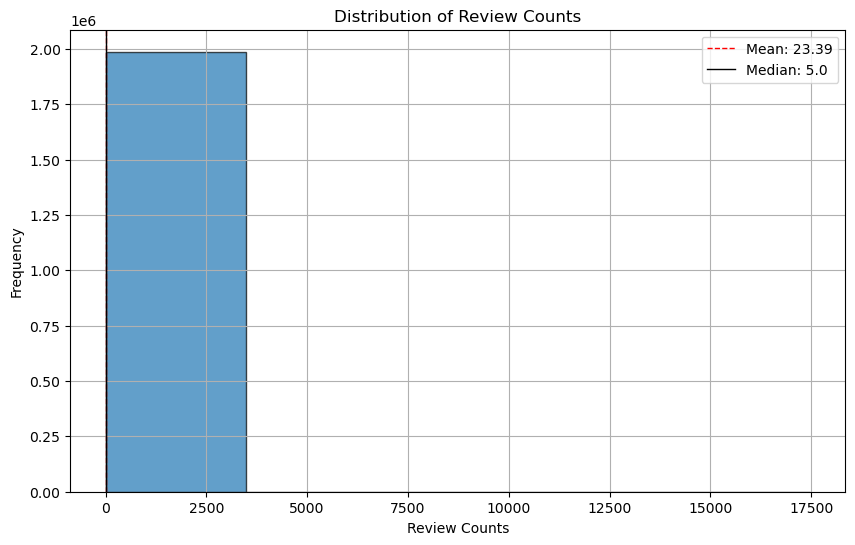

In [50]:
# Review count distribution
plot_distribution(df_u, 'review_count', 'Distribution of Review Counts', 'Review Counts','Frequency', bins=5)

Similar to the number of reviews a business receives, in this data set although hard to see, some users are very prolific reviewers, but the vast majority of the number of user reviews lies somewhere between the median and the mean.

## Average Stars
Column contains average of all user ratings for businesses  

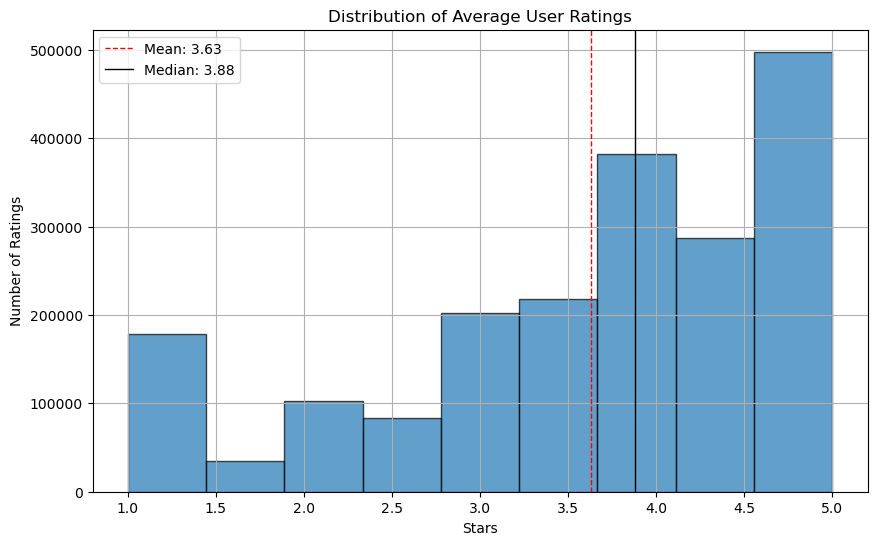

In [51]:
# Average star distribution
plot_distribution(df_u, 'average_stars', 'Distribution of Average User Ratings', 'Stars','Number of Ratings', bins=9)

Similar to the business ratings, this has a right skew. Users tend to give 4+ star reviews. However, many users just review businesses to express their displeasure, as there are about 18000 users with an average review score of 1.

# Review Data Set
#### Data Dictionary
Contains full review text data including the user_id that wrote the review and the business_id the review is written for.<br/>
Info sourced from the data set [documentation](https://www.yelp.com/dataset/documentation/main)<br/>

| COLUMN NAME  | DESCRIPTION                                                   | DATA TYPE |
|--------------|---------------------------------------------------------------|-----------|
| `review_id`  | Unique identifier for each review (22 character string)       | string    |
| `user_id`    | Unique identifier for each user (22 character string)         | string    |
| `business_id`| Unique identifier for businesses (22 character string)        | string    |
| `stars`      | Star rating given to the business (integer)                   | int       |
| `date`       | Date formatted YYYY-MM-DD                                     | string    |
| `text`       | The review itself                                             | string    |
| `useful`     | Number of useful votes received (integer)                     | int       |
| `funny`      | Number of funny votes received (integer)                      | int       |
| `cool`       | Number of cool votes received (integer)                       | int       |

##### Loading Data
- Similar to the previous JSON file this contains multiple JSON objects, each representing a different users.
- I'm going to go ahead and exclude objects the contain null values for certain fields such as ids, date, and stars. These fields are necessary for either modeling or for filtering purposes.
- I'll also remove metadata not relevant to current modelling procedure this is especially important for this large data set to conserve memory.

In [53]:
# Function to filter the review data
def filter_review_data(review):
    return {
        'review_id': review.get('review_id'),
        'user_id': review.get('user_id'),
        'business_id': review.get('business_id'),
        'stars': review.get('stars'),
        'date': review.get('date'),
    }
# List of required fields
required_fields = ['user_id', 'review_id', 'business_id', 'stars']

# Initialize an empty list to store the filtered users
data = []

# Load and filter the JSON file line by line
with open('../Data/original_data_sets/yelp_academic_dataset_review.json', 'r') as file:
    for line in file:
        try:
            entry = json.loads(line)
            # Check if all required fields are present and not null
            if all(field in entry and entry[field] is not None for field in required_fields):
                # Using function to only return specific user data
                filter_review = filter_review_data(entry)
                data.append(filter_review)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON on line: {line}")
            print(e)

# Checking the number of entries
num_entries = len(data)
print(f"Number of entries: {num_entries}")


Number of entries: 6990280


In [55]:
# Inspecting the first entry to understand the structure
print("\nSample entry:")
print(json.dumps(data[0], indent=3))


Sample entry:
{
   "review_id": "KU_O5udG6zpxOg-VcAEodg",
   "user_id": "mh_-eMZ6K5RLWhZyISBhwA",
   "business_id": "XQfwVwDr-v0ZS3_CbbE5Xw",
   "stars": 3.0,
   "date": "2018-07-07 22:09:11"
}


In [56]:
# All unique keys at the top level
keys = set()
for entry in data:
    keys.update(entry.keys())
print(f"\nTop-level keys: {list(keys)}")


Top-level keys: ['business_id', 'stars', 'user_id', 'date', 'review_id']


In [57]:
# Summarize data types for each key
data_types = defaultdict(set)
for entry in data:
    for key, value in entry.items():
        data_types[key].add(type(value).__name__)

print("\nData Types:")
for key, types in data_types.items():
    print(f"{key}: {', '.join(types)}")


Data Types:
review_id: str
user_id: str
business_id: str
stars: float
date: str


In [58]:
# Checking missing values using function defined earlier
missing_values = check_missing_values(data)
print("Missing Values:")
for key, count in missing_values.items():
    print(f"{key}: {count} missing values")

Missing Values:
business_id: 0 missing values
stars: 0 missing values
user_id: 0 missing values
date: 0 missing values
review_id: 0 missing values


In [59]:
# Checking duplicate reviews using function defined earlier
check_duplicate_ids(data, 'review_id')

,review_id,count


In [60]:
# Convert the filtered list of dictionaries to a pandas DataFrame
df_r = pd.DataFrame(data)
df_r.head()

,review_id,user_id,business_id,stars,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,2017-01-14 20:54:15


In [61]:
# Gives me a a quick look at the data types for each column, number of entries, and columns.
df_r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6990280 entries, 0 to 6990279
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   review_id    object 
 1   user_id      object 
 2   business_id  object 
 3   stars        float64
 4   date         object 
dtypes: float64(1), object(4)
memory usage: 266.7+ MB


The data set needs minimal cleaning; there is definitely a lot of value to be discovered as I explore relationships between users, businesses, and their ratings. 

## Unique Identifiers
The first column contains a unique identifier for each review. The second and Third columns act as foreign keys to link with the business and user data tables.  

## Stars
Column contains the rating between 1 and 5 given to the specified business.Users can only give whole ratings.

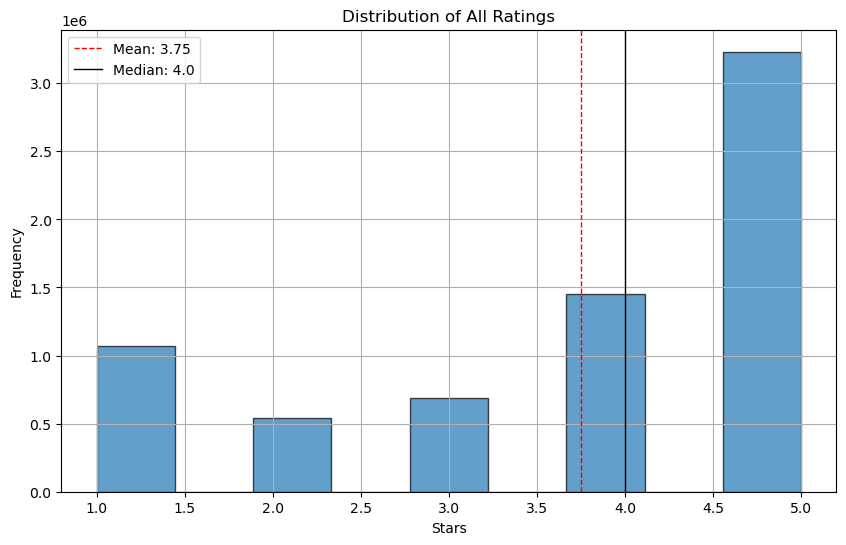

In [62]:
# Star distribution for all reviews
plot_distribution(df_r, 'stars', 'Distribution of All Ratings', 'Stars','Frequency', bins=9)

## Date
Column contains a date-time object for the date the review was submitted. 

In [63]:
# Convert to date time
df_r['date'] = pd.to_datetime(df_r['date'])

In [64]:
# Verify Changes
df_r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6990280 entries, 0 to 6990279
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   review_id    object        
 1   user_id      object        
 2   business_id  object        
 3   stars        float64       
 4   date         datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 266.7+ MB


In [65]:
# Save total reviews per year to new df
reviews_grouped_year = df_r.groupby(df_r.date.dt.year)['review_id'].count()

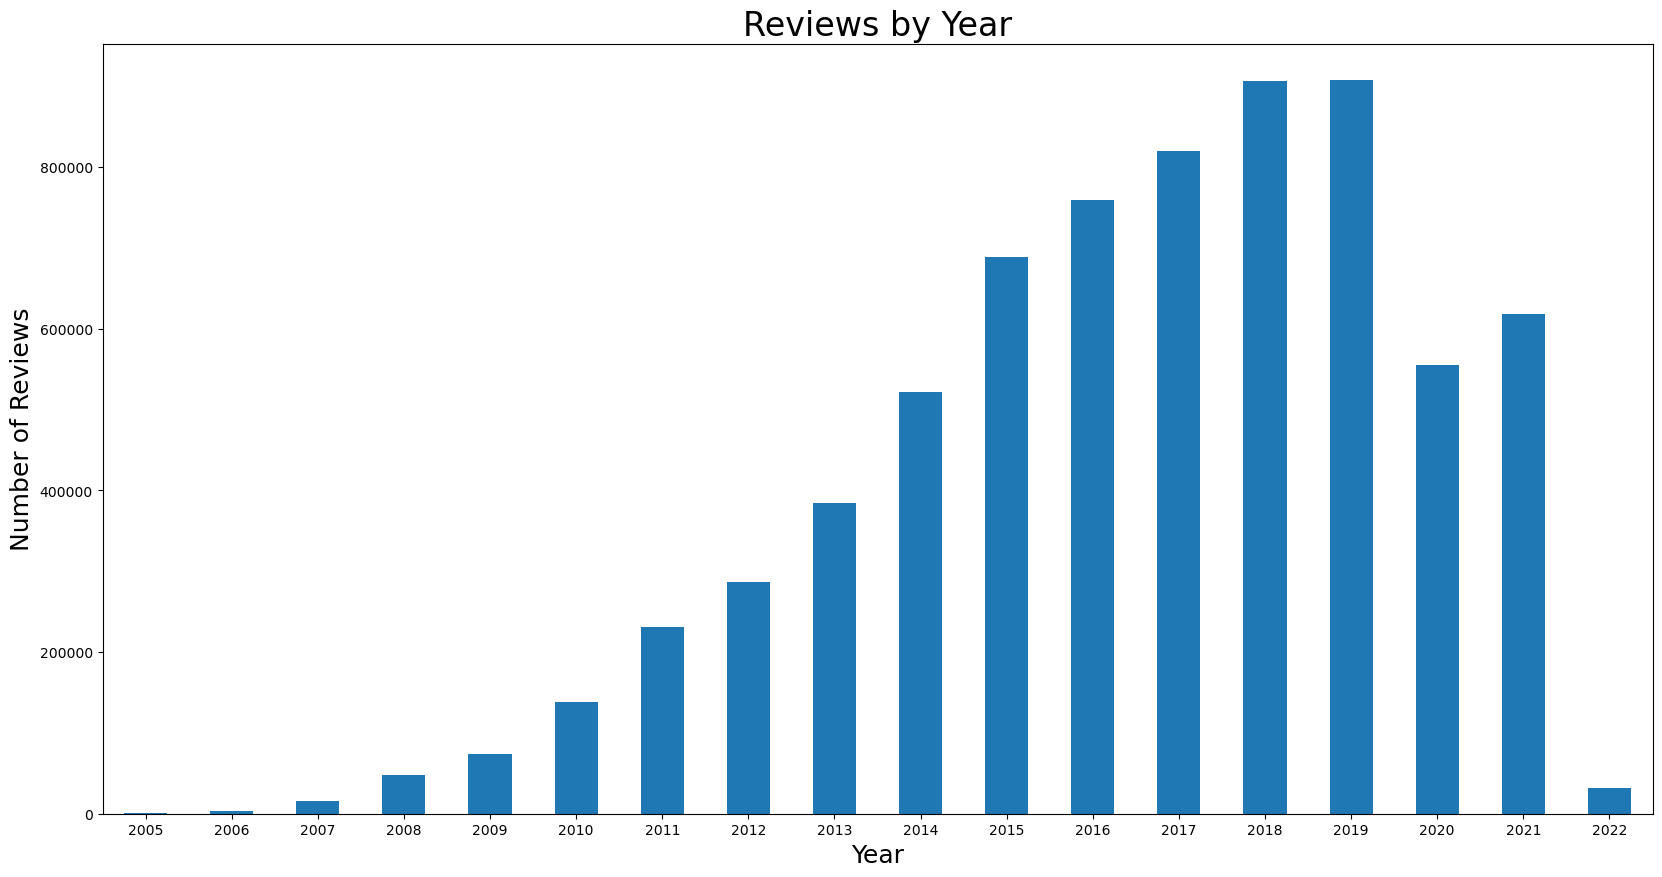

In [66]:
# Plot that shows distribution of reviews by year.
reviews_grouped_year.plot.bar(figsize=(20,10))

# Rotating X-axis labels
plt.xticks(rotation = 0)
 
# Setting title and axis labels
plt.title('Reviews by Year', size=24)
plt.xlabel("Year", size=18)
plt.ylabel("Number of Reviews", size=18)

# Save distribution to file
#plt.savefig('figures/ReviewsByYear.png')
 
# Show plot
plt.show()

# Exporting Data
Run the cell below to generate files necessary for next steps. 

In [71]:
# export prepared data for businesses, users, and reviews
df_b.to_parquet('../Data/cleaned_data_sets/dataset_business.parquet', index=False) #Setting index=False to drop index column
df_u.to_parquet('../Data/cleaned_data_sets/dataset_user.parquet', index=False)
df_r.to_parquet('../Data/cleaned_data_sets/dataset_review.parquet', index=False)